/tmp/ipykernel_251104/2163291118.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn")


Plotting interpolations of experimental data


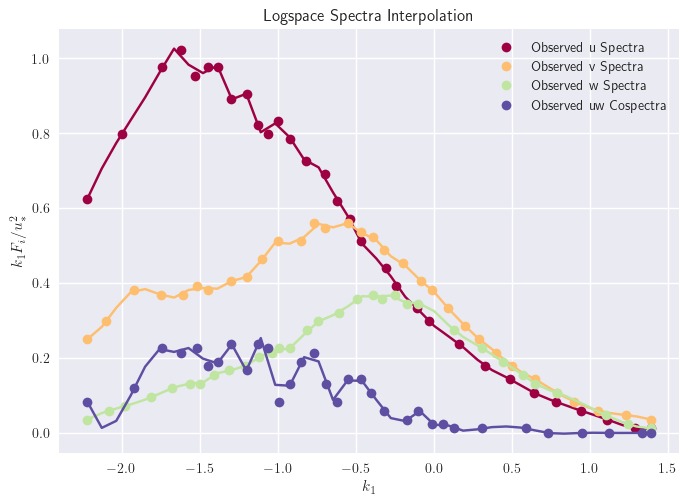

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

# %%
import numpy as np
import torch
import torch.nn as nn

from drdmannturb.calibration import CalibrationProblem
from drdmannturb.data_generator import OnePointSpectraDataGenerator
from drdmannturb.interpolation import extract_x_spectra, interpolate
from drdmannturb.shared.enums import DataType
from drdmannturb.shared.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)

path = Path().resolve()
datapath = (
    path / "../docs/source/data" if path.name == "examples" else path / "../data/"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

# %% [markdown]
# ## Extract Data from Provided CSVs

# %%
# for interpolation, log10-scaled k1 is used, regular values of the domain used for fitting
x_coords_u, u_spectra = extract_x_spectra(datapath / "u_spectra.csv")
x_coords_v, v_spectra = extract_x_spectra(datapath / "v_spectra.csv")
x_coords_w, w_spectra = extract_x_spectra(datapath / "w_spectra.csv")
x_coords_uw, uw_cospectra = extract_x_spectra(datapath / "uw_cospectra.csv")
x_interp, interp_u, interp_v, interp_w, interp_uw = interpolate(
    datapath, num_k1_points=40, plot=True
)

domain = torch.tensor(x_interp)

L = 0.59
Gamma = 3.9
sigma = 3.2
Uref = 21.0

In [2]:
f = domain
k1_data_pts = 2 * torch.pi * f / Uref

DataPoints = [(k1, 1) for k1 in k1_data_pts]
x_full = [x_coords_u, x_coords_v, x_coords_w, x_coords_uw]
spectra_full = [u_spectra, v_spectra, w_spectra, uw_cospectra]
spectra_values = np.stack((interp_u, interp_v, interp_w, interp_uw), axis=1)

# %%
Datagen = OnePointSpectraDataGenerator(
    data_points=DataPoints,
    data_type=DataType.AUTO,
    k1_data_points=(
        k1_data_pts.cpu().numpy() if torch.cuda.is_available() else k1_data_pts.numpy()
    ),
    spectra_values=spectra_values,
)

Data = Datagen.Data

Filtering provided spectra interpolation: 
[fit u spectra]
---------------------
RMSE: 0.0306845781823255
R-squared: 0.9923822120712771
---------------------
[fit v spectra]
---------------------
RMSE: 0.06655568019186855
R-squared: 0.8362598440331215
---------------------
[fit w spectra]
---------------------
RMSE: 0.021661706943741213
R-squared: 0.9631571380884996
---------------------
[fit uw cospectra]
---------------------
RMSE: 0.03302925293012712
R-squared: 0.8525919464352417


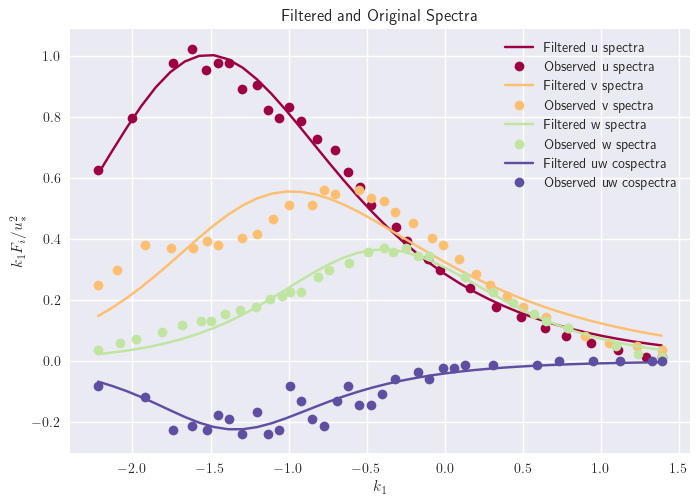

In [3]:
Datagen.plot(x_interp, spectra_full, x_full)

In [4]:
x_full[0].shape, spectra_values.shape

((31,), (40, 4))